In [1]:
""" 
MIMIC experiment based on the dataset prepared by prepare_admid_diagnosis.ipynb

The features are the full set of ICD codes, the labele are generated by whether \
    the patient diagnosis contains target diagnosis (i.e., lung cancer in diagnose text description)
"""

' \nMIMIC experiment based on the dataset prepared by prepare_admid_diagnosis.ipynb\n\nThe features are the ICD codes, the labele are generated by whether the patient diagnosis contains target diagnosis (i.e., lung cancer)\n'

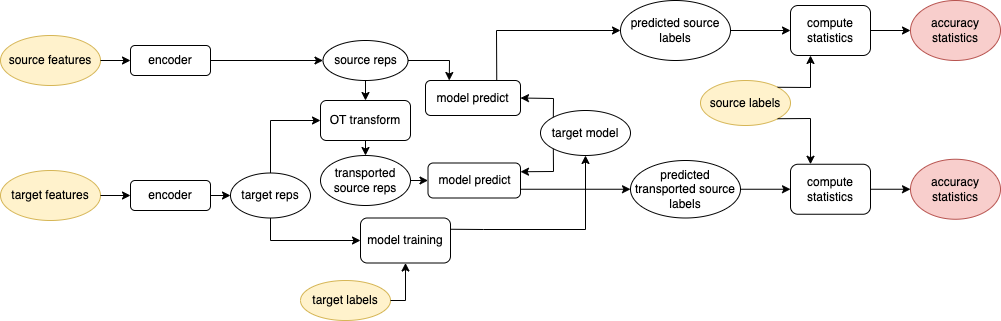

In [3]:
from IPython.display import Image
Image(filename='../../outputs/pipeline_figs/EHR_MIMIC_pipeline.png')

In [4]:
import sys
sys.path.append("/home/wanxinli/OTTEHR/")

from common import *
from ast import literal_eval
# %matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import random
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


In [5]:
""" 
Read in dataframe
"""
admid_diagnosis_df = pd.read_csv("../../outputs/mimic/ADMID_DIAGNOSIS.csv", index_col=0, header=0, converters={'ICD codes': literal_eval})
admid_diagnosis_df

,adm_type,gender,ICD codes,duration,diagnosis,label
admid,,,,,,
172335,EMERGENCY,F,"[40301, 486, 58281, 5855, 4254, 2762, 7100, 27...",530460.0,LEG PAIN,0
173633,EMERGENCY,F,"[40301, 5856, 58381, 7100, 5589, 2875, 28521, ...",574560.0,ABDOMINAL PAIN,0
174105,EMERGENCY,M,"[53100, 41071, 2859, 41401, 725]",425460.0,GASTROINTESTINAL BLEED,0
109976,EMERGENCY,M,"[1915, 3314, 53081]",1284240.0,HYDROCEPHALUS,0
178393,ELECTIVE,M,"[41401, 4111, 48283, 2859, 2720, 3051]",485280.0,USA/SDA,0
...,...,...,...,...,...,...
172304,ELECTIVE,F,"[20280, 3485, 7843, 4019, 2720, 53081]",449700.0,LEFT BRAIN TUMOR/SDA,0
152542,EMERGENCY,M,"[566, 25062, 3572, V5867, 42731, 4019, 4280, 5...",415740.0,PERIRECTAL ABSCESS,0
161999,EMERGENCY,M,"[43411, 3485, 3484, 430, 34830, 99731, 51883, ...",692940.0,STROKE;TELEMETRY,0


In [6]:
""" 
Print number of patients for each category
"""
print("female label 0", admid_diagnosis_df.loc[(admid_diagnosis_df['label'] == 0) & (admid_diagnosis_df['gender'] == 'F')].shape[0])
print("female label 1", admid_diagnosis_df.loc[(admid_diagnosis_df['label'] == 1) & (admid_diagnosis_df['gender'] == 'F')].shape[0])
print("male label 0", admid_diagnosis_df.loc[(admid_diagnosis_df['label'] == 0) & (admid_diagnosis_df['gender'] == 'M')].shape[0])
print("male label 1", admid_diagnosis_df.loc[(admid_diagnosis_df['label'] == 1) & (admid_diagnosis_df['gender'] == 'M')].shape[0])

female label 0 25926
female label 1 100
male label 0 32801
male label 1 149


In [7]:
def select_df(df, male_count, female_count):
    """ 
    Select row in the dataframe df with balanced number of labels for males and females
    Specifically, we want to reduce the number of rows with label 0 for males and females

    :param Dataframe df: the dataframe to select samples with label 0 and label 1
    :param int target_count: the number of samples with label 1s and label 0s for target (male). 
    :param int source_count: the number of samples with label 1s and label 0s for source (female). 
    """

    female_1_indices = []
    female_0_indices = []
    male_1_indices = []
    male_0_indices = []

    for index, row in df.iterrows():
        if row['label'] == 0 and row['gender'] == 'F':
            female_0_indices.append(index)
        elif row['label'] == 0 and row['gender'] == 'M':
            male_0_indices.append(index)
        elif row['label'] == 1 and row['gender'] == 'F':
            female_1_indices.append(index)
        elif row['label'] == 1 and row['gender'] == 'M':
            male_1_indices.append(index)
    
    # indices to delete from the dataframe
    # sample the same number of label 0s and label 1s
    delete_female_0_indices = random.sample(female_0_indices, len(female_0_indices)-female_count)
    delete_male_0_indices = random.sample(male_0_indices, len(male_0_indices)-male_count)
    delete_female_1_indices = random.sample(female_1_indices, len(female_1_indices)-female_count)
    delete_male_1_indices = random.sample(male_1_indices, len(male_1_indices)-male_count)

    delete_female_0_indices.extend(delete_male_0_indices)
    delete_female_0_indices.extend(delete_female_1_indices)
    delete_female_0_indices.extend(delete_male_1_indices)
    
    new_df = df.drop(delete_female_0_indices, axis=0, inplace=False)
    return new_df


In [38]:
male_count = 120
female_count = 50
admid_diagnosis_select_df = select_df(admid_diagnosis_df, male_count=male_count, female_count=female_count)


""" 
Print number of patients for each category
"""
print("female label 0", admid_diagnosis_select_df.loc[(admid_diagnosis_select_df['label'] == 0) & (admid_diagnosis_select_df['gender'] == 'F')].shape[0])
print("female label 1", admid_diagnosis_select_df.loc[(admid_diagnosis_select_df['label'] == 1) & (admid_diagnosis_select_df['gender'] == 'F')].shape[0])
print("male label 0", admid_diagnosis_select_df.loc[(admid_diagnosis_select_df['label'] == 0) & (admid_diagnosis_select_df['gender'] == 'M')].shape[0])
print("male label 1", admid_diagnosis_select_df.loc[(admid_diagnosis_select_df['label'] == 1) & (admid_diagnosis_select_df['gender'] == 'M')].shape[0])


female label 0 50
female label 1 50
male label 0 120
male label 1 120


In [39]:
def update_codes(df):
    """ 
    Update code in dataframe, the new code starts from 0.
    We use -1 to denote NA code in later analysis

    returns
        - a new dataframe with the updated codes
        - total number of unique codes in df
    """
    new_code_dict = {} # mapping from old code to new code
    for index, row in df.iterrows():
        cur_codes = row['ICD codes']
        new_codes = []
        for code in cur_codes:
            if code not in new_code_dict:
                new_code_dict[code] = len(new_code_dict) # add a new entry
            new_codes.append(new_code_dict[code])
        df.at[index, 'ICD codes'] = new_codes
    return df, len(new_code_dict)


In [58]:

def plot_code_distn(df):
    """ 
    Plot code distribution for males and females, (codes are updated)

    We hope the distributions for males and females are different

    Note: we prefer not to use the updated codes directly afterwards. 

    """

    df, _ = update_codes(df)
    # print(admid_diagnosis_df)
    female_1_df = df.loc[(df['label'] == 1) & (df['gender'] == 'F')]
    male_1_df = df.loc[(df['label'] == 1) & (df['gender'] == 'M')]
    female_0_df = df.loc[(df['label'] == 0) & (df['gender'] == 'F')]
    male_0_df = df.loc[(df['label'] == 0) & (df['gender'] == 'M')]
    print("female_1_df.shape is:", female_1_df.shape)
    print("female_0_df.shape is:", female_0_df.shape)
    print("male_1_df.shape is:", male_1_df.shape)
    print("male_0_df.shape is:", male_0_df.shape)
    bin_width = 1

    plt.subplot(2,2,1)
    female_1_codes = female_1_df['ICD codes']
    female_1_codes = [code for sublist in female_1_codes for code in sublist]
    plt.hist(female_1_codes, bins=range(min(female_1_codes), max(female_1_codes)+bin_width, bin_width))
    plt.title("female label 1")

    plt.subplot(2,2,2)
    male_1_codes = male_1_df['ICD codes']
    male_1_codes = [code for sublist in male_1_codes for code in sublist]
    plt.hist(male_1_codes, bins=range(min(male_1_codes), max(male_1_codes)+bin_width, bin_width))
    plt.title("male label 1")

    plt.subplot(2,2,3)
    female_0_codes = female_0_df['ICD codes']
    female_0_codes = [code for sublist in female_0_codes for code in sublist]
    plt.hist(female_0_codes, bins=range(min(female_0_codes), max(female_0_codes)+bin_width, bin_width))
    plt.title("female label 0")

    plt.subplot(2,2,4)
    male_0_codes = male_0_df['ICD codes']
    male_0_codes = [code for sublist in male_0_codes for code in sublist]
    plt.hist(male_0_codes, bins=range(min(male_0_codes), max(male_0_codes)+bin_width, bin_width))
    plt.title("male label 0")

    plt.tight_layout()
    plt.show()


female_1_df.shape is: (50, 6)
female_0_df.shape is: (50, 6)
male_1_df.shape is: (120, 6)
male_0_df.shape is: (120, 6)


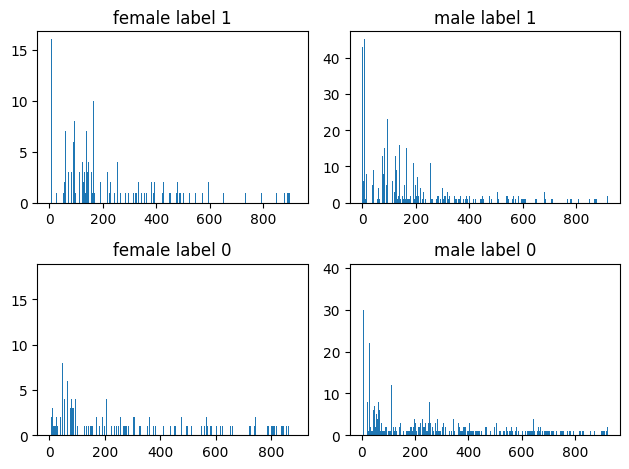

In [59]:
plot_code_distn(admid_diagnosis_select_df)

In [41]:
def generate_features_labels(df):
    """ 
    Generate source features, source labels, target features and target labels from dataframe df

    TODO: consider making the labels balanced (currently way more 0s than 1s)
    """

    _, num_codes = update_codes(df)

    source_df = df.loc[df['gender'] == 'F']
    target_df = df.loc[df['gender'] == 'M']

    # Prepare target
    target_features = np.empty(shape=[target_df.shape[0], num_codes])
    feature_index = 0
    for _, row in target_df.iterrows():
        code_ind = np.zeros(num_codes)
        for code in row["ICD codes"]:
            code_ind[code] += 1
        target_features[feature_index] = code_ind
        feature_index += 1
    target_labels = np.array(list(target_df['label']))

    # Prepare source
    source_features = np.empty(shape=[source_df.shape[0], num_codes])
    feature_index = 0
    for _, row in source_df.iterrows():
        code_ind = np.zeros(num_codes)
        for code in row["ICD codes"]:
            code_ind[code] += 1
        source_features[feature_index] = code_ind
        feature_index += 1
    source_labels = np.array(list(source_df['label']))

    return target_features, target_labels, source_features, source_labels


In [42]:
target_features, target_labels, source_features, source_labels = generate_features_labels(admid_diagnosis_select_df)


In [43]:
target_features.shape, target_labels.shape, source_features.shape, source_labels.shape

((240, 925), (240,), (100, 925), (100,))

In [44]:
"""
Train deep patient model and generate representations for targets and sources
"""

def custom_train_reps(target_features, source_features, n_components, pca_explain=False):
    """ 
    Customized training algorithm for generating target representations and source representations

    :param bool pca_explain: print the explained variance of each components
    
    :returns: target representations, source representations
    """
    source_pca = PCA(n_components=n_components)
    target_pca = PCA(n_components=n_components)
    target_reps = target_pca.fit_transform(target_features)
    source_reps = source_pca.fit_transform(source_features)

    if pca_explain:
        source_exp_var = source_pca.explained_variance_ratio_
        source_cum_sum_var = np.cumsum(source_exp_var)
        target_exp_var = target_pca.explained_variance_ratio_
        target_cum_sum_var = np.cumsum(target_exp_var)
        print("Cummulative variance explained by the source PCA is:", source_cum_sum_var)
        print("Cummulative variance explained by the target PCA is:", target_cum_sum_var)

    return target_reps, source_reps

In [45]:
target_reps, source_reps = custom_train_reps(target_features, source_features, n_components=50, pca_explain=True)


Cummulative variance explained by the source PCA is: [0.05852563 0.09894647 0.13592105 0.16977924 0.2011711  0.22940445
 0.2566     0.28246443 0.30788137 0.33250481 0.35519546 0.37706999
 0.39840977 0.41807621 0.43689273 0.45446136 0.47174946 0.48845616
 0.50481876 0.52109981 0.53650305 0.55145659 0.56591191 0.58002023
 0.59336343 0.60594608 0.61839816 0.63057408 0.64215157 0.65349728
 0.6646785  0.67541514 0.68590478 0.69623279 0.70629136 0.71592376
 0.72542661 0.73482864 0.74400158 0.75266009 0.76116652 0.76942238
 0.77757296 0.78542023 0.79309887 0.80046949 0.80782382 0.81495845
 0.82172    0.8284046 ]
Cummulative variance explained by the target PCA is: [0.03691458 0.06636515 0.09437258 0.11890174 0.1406957  0.16167513
 0.18017172 0.19805704 0.21474693 0.23124036 0.24706046 0.26140835
 0.27560193 0.28923913 0.30266891 0.31580103 0.32857394 0.34087692
 0.35293798 0.36446395 0.37560542 0.38626901 0.39675336 0.40708551
 0.41696004 0.42653887 0.435944   0.44525997 0.45428298 0.46321057

In [46]:
target_reps.shape, source_reps.shape

((240, 50), (100, 50))

In [47]:
""" 
Fit the model, transport and make predictions
"""
clf = LogisticRegression()
clf.fit(target_reps, target_labels)
target_preds = clf.predict(target_reps)
source_preds = clf.predict(source_reps)
trans_source_reps = trans_source2target(source_reps, target_reps)
trans_source_preds = clf.predict(trans_source_reps)

In [48]:
""" 
Print the accuracy stats
"""

print("target accuracy is:", accuracy_score(target_labels, target_preds))
print("target precision is:", precision_score(target_labels, target_preds))
print("target recall is:", recall_score(target_labels, target_preds))
print("source accuracy is:", accuracy_score(source_labels, source_preds))
print("source precision is:", precision_score(source_labels, source_preds))
print("source recall is:", recall_score(source_labels, source_preds))
print("trans source accuracy is:", accuracy_score(source_labels, trans_source_preds))
print("trans source precision is:", precision_score(source_labels, trans_source_preds))
print("trans source recall is:", recall_score(source_labels, trans_source_preds))

target accuracy is: 0.9208333333333333
target precision is: 0.9391304347826087
target recall is: 0.9
source accuracy is: 0.59
source precision is: 0.6
source recall is: 0.54
trans source accuracy is: 0.56
trans source precision is: 0.5625
trans source recall is: 0.54


In [49]:
""" 
Automate this process
"""

def entire_proc(n_components, male_count = 120, female_count = 100):
    """
    Wrap up the entire procedure

    :param int n_components: the number of components for PCA learning
    :param int male_count: the number of samples with label 1s and label 0s for target (male). 
    :param int female_count: the number of samples with label 1s and label 0s for source (female). 
    """
    
    admid_diagnosis_select_df = select_df(admid_diagnosis_df, male_count=male_count, female_count=female_count)

    target_features, target_labels, source_features, source_labels = generate_features_labels(admid_diagnosis_select_df)

    target_reps, source_reps = custom_train_reps(target_features, source_features, n_components)

    clf = LogisticRegression()
    clf.fit(target_reps, target_labels)
    target_preds = clf.predict(target_reps)
    source_preds = clf.predict(source_reps)
    trans_source_reps = trans_source2target(source_reps, target_reps)
    trans_source_preds = clf.predict(trans_source_reps)
    target_accuracy = accuracy_score(target_labels, target_preds)
    target_f1 = f1_score(target_labels, target_preds)
    source_accuracy = accuracy_score(source_labels, source_preds)
    source_f1 = f1_score(source_labels, source_preds)
    trans_source_accuracy = accuracy_score(source_labels, trans_source_preds)
    trans_source_f1 = f1_score(source_labels, trans_source_preds)
    return target_accuracy, target_f1, source_accuracy, source_f1, \
        trans_source_accuracy, trans_source_f1


In [50]:
""" 
Run one iteartion
"""

entire_proc(50)

(0.925,
 0.9224137931034484,
 0.405,
 0.3703703703703704,
 0.425,
 0.42786069651741293)

In [51]:
def multi_proc(score_path, n_components = 10, iteration=20):
    """ 
    :param str score_path: path to save score
    """

    # we consier accuracy and f1 score at the moment
    res = np.empty(shape=[iteration, 6])
    for i in range(iteration):
        print("iteration:", i)
        cur_res = entire_proc(n_components)
        res[i] = cur_res
    res_df = pd.DataFrame(res, columns = ['target_accuracy', 'target_f1', 'source_accuracy', 'source_f1', 'trans_source_accuracy', 'trans_source_f1'])
    res_df.to_csv(score_path, index=False, header=True)
    return res
    

In [55]:
""" 
Run multiple iteations
"""
score_path = "../../outputs/mimic/exp2_score.csv"
res = multi_proc(score_path, n_components = 50, iteration=200)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18


/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24


/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
iteration: 72
iteration: 73
iteration: 74
iteration: 75
iteration: 76
iteration: 77
iteration: 78
iteration: 79
iteration: 80
iteration: 81
iteration: 82
iteration: 83
iteration: 84
iteration: 85
iteration: 86
iteration: 87
iteration: 88
iteration: 89
iteration: 90
iteration: 91
iteration: 92
iteration: 93
iteration: 94
iteration: 95
iterat

/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 100
iteration: 101
iteration: 102
iteration: 103
iteration: 104
iteration: 105
iteration: 106
iteration: 107
iteration: 108
iteration: 109
iteration: 110
iteration: 111
iteration: 112
iteration: 113
iteration: 114
iteration: 115
iteration: 116


/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 117
iteration: 118
iteration: 119
iteration: 120
iteration: 121
iteration: 122
iteration: 123
iteration: 124


/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 125
iteration: 126
iteration: 127
iteration: 128
iteration: 129
iteration: 130
iteration: 131
iteration: 132
iteration: 133
iteration: 134
iteration: 135
iteration: 136
iteration: 137
iteration: 138
iteration: 139
iteration: 140
iteration: 141
iteration: 142
iteration: 143
iteration: 144
iteration: 145
iteration: 146
iteration: 147
iteration: 148
iteration: 149
iteration: 150
iteration: 151
iteration: 152
iteration: 153
iteration: 154
iteration: 155
iteration: 156
iteration: 157
iteration: 158
iteration: 159
iteration: 160


/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 161
iteration: 162
iteration: 163
iteration: 164
iteration: 165
iteration: 166


/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 167


/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 168
iteration: 169
iteration: 170
iteration: 171
iteration: 172
iteration: 173
iteration: 174
iteration: 175
iteration: 176
iteration: 177
iteration: 178


/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 179
iteration: 180
iteration: 181


/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 182
iteration: 183
iteration: 184
iteration: 185
iteration: 186
iteration: 187


/home/wanxinli/.local/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


iteration: 188
iteration: 189
iteration: 190
iteration: 191
iteration: 192
iteration: 193
iteration: 194
iteration: 195
iteration: 196
iteration: 197
iteration: 198
iteration: 199


number of stats is: 200
number of 0 in incre is: 5
number of elements > 0 is: 135
number of elements < 0 is: 60
average trans source to source accuracy increment is: 0.034550000000000004
median trans source to source accuracy increment is: 0.035
average trans source to source accuracy f1 is: 0.022640700412941958
median trans source to source accuracy f1 is: 0.024282388607838656
average trans source to source accuracy is: 1.0960592237269025
median trans source to source accuracy is: 1.0693850267379679
average trans source to source f1 is: 1.0661435047502608
median trans source to source f1 is: 1.0463691199716034


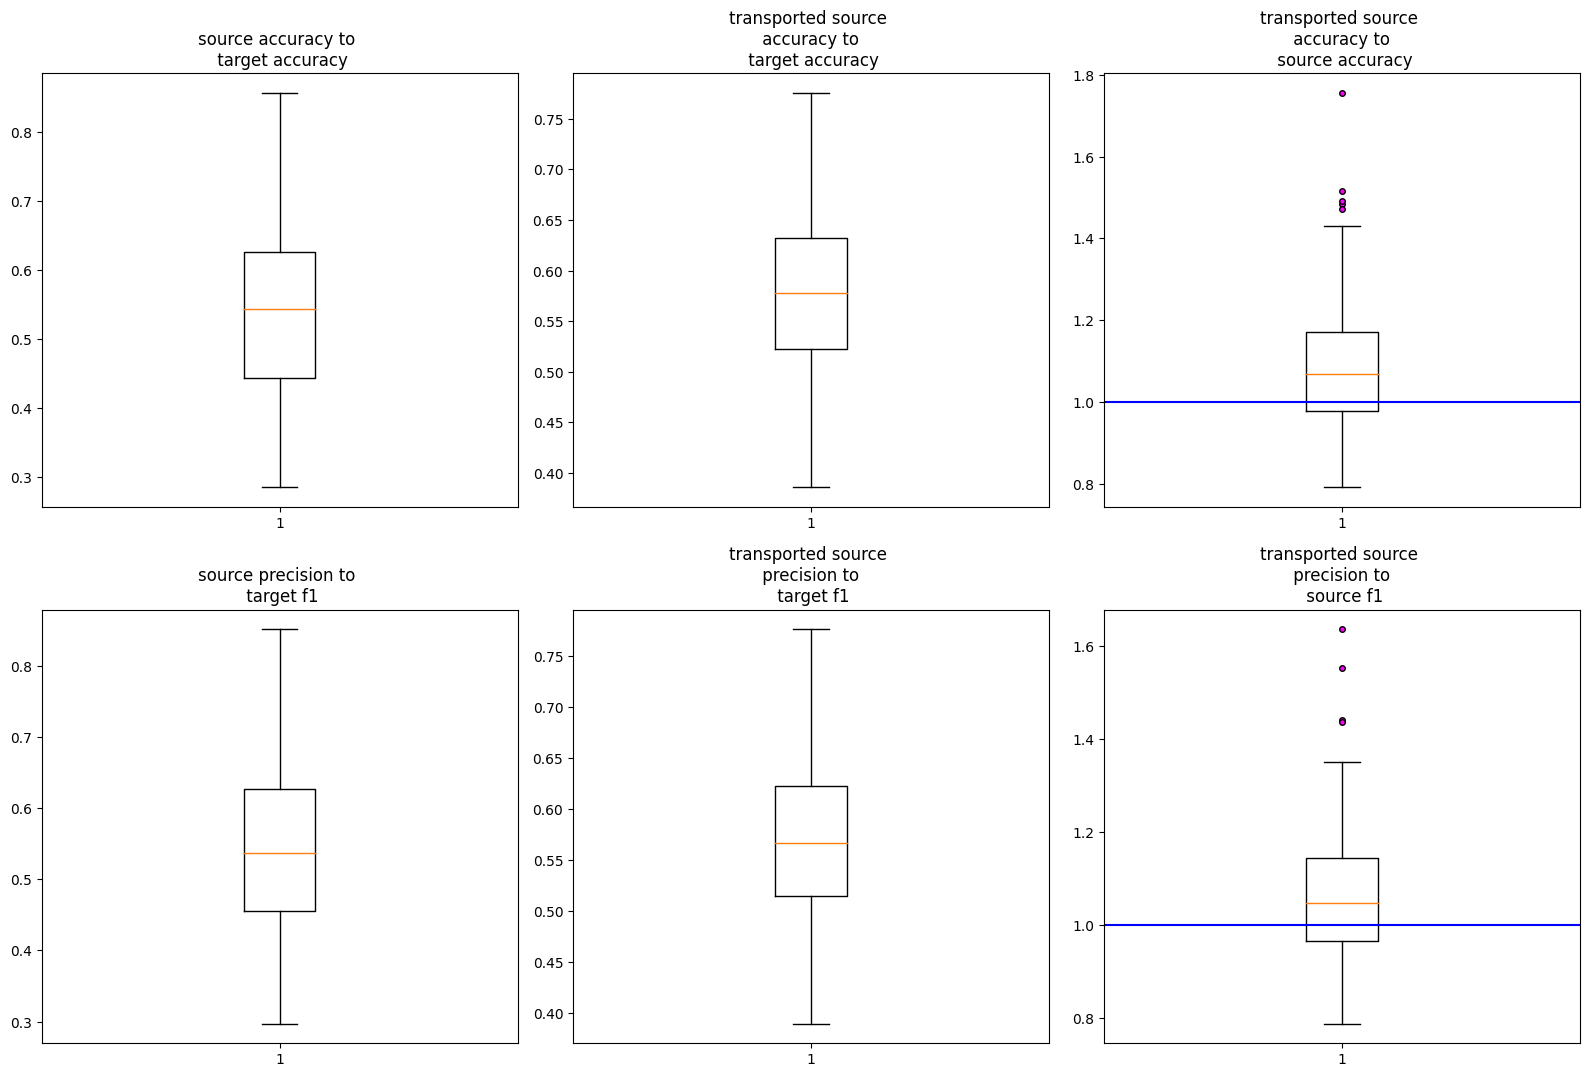

In [56]:
box_plot("../../outputs/mimic/score.csv", filter=False)

average trans source to source accuracy increment is 3.5%
median trans source to source accuracy increment is 3.5%
average trans source to source accuracy f1 is 2.3%
median trans source to source accuracy f1 is 2.4%


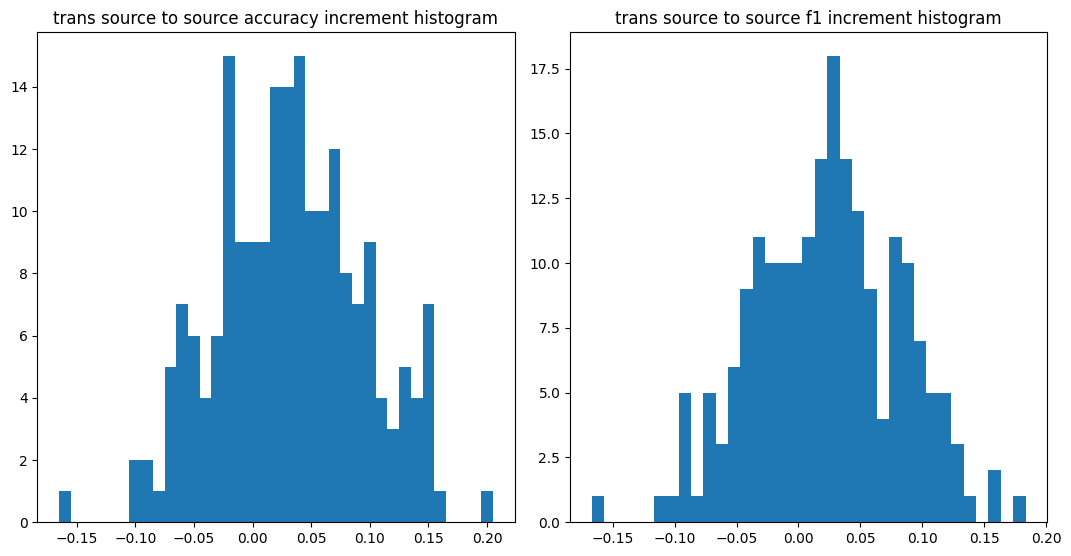

In [57]:
hist_plot("../../outputs/mimic/score.csv", filter=False)

In [26]:
def vis_emb_dim3_unordered(target_reps, target_labels, source_reps, source_labels, \
    trans_source_reps):
    """ 
    Visualize the embedding space of dimension 3 for target represenatations, source representations, \
        transported source representations with different labels annotated in different colors
    """
    fig = plt.figure(figsize=[10, 4])

    ax = fig.add_subplot(1,3,1, projection='3d')
    cdict = {1: 'purple', 0: 'orange'}
    
    for l in np.unique(target_labels):
        ix = np.where(target_labels == l)
        ax.scatter(target_reps[ix, 0], target_reps[ix, 1], target_reps[ix, 2], label = l, s = 5, color=cdict[l])
    ax.legend()
    ax.set_title("Target")

    ax = fig.add_subplot(1,3,2, projection='3d')
    for l in np.unique(source_labels):
        ix = np.where(source_labels == l)
        ax.scatter(source_reps[ix, 0], source_reps[ix, 1], source_reps[ix, 2], label = l, s = 5, color=cdict[l])
    ax.legend()
    ax.set_title("Source")

    ax = fig.add_subplot(1,3,3, projection='3d')
    for l in np.unique(source_labels):
        ix = np.where(source_labels == l)
        ax.scatter(trans_source_reps[ix, 0], trans_source_reps[ix, 1], trans_source_reps[ix, 2], label = l, s = 5, color=cdict[l])
    ax.legend()
    ax.set_title("Trans source")
    
    plt.show()
    
